In [11]:
import h5py
from string import Template
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt, cm
import ipywidgets as widgets
import itertools
#!pip install tqdm
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
#
#from pyestimate import sin_param_estimate

def integrate_q(data,q,q_roi, norm_sum):
    """checked by Christian"""
    q_start, q_stop = q_roi
    start_index = np.where(q>=q_start)[0][0]
    stop_index = np.where(q>=q_stop)[0][0]
    azimutal_integrated = np.sum(data[...,start_index:stop_index]*norm_sum[:,start_index:stop_index] ,axis=(2,3))
    norm = np.sum(norm_sum[:,start_index:stop_index], axis=(0,1))
    output = np.divide(azimutal_integrated ,norm , out=np.zeros_like(azimutal_integrated))
    return output

def load_data(proposal,visit,scan, det, fly_scan, cluster='maxiv'):
    """keys in file that will be loaded
        **FROM AZINT FILE**
        'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
        'azi', : azimuthal bins
        'mask_file', : file path for mask used for radial integration
        'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
        'polarization_factor', : polarisation factor used for integration
        'poni_file', : file path for pony file
        'q', : q Vektor for integration
        **FROM MASTER FILE**
        'i_t', : diode data, transmittance for 2D map
        'dt' : exposure time from eiger/lambda/diode
        'title' :  scan command from SPOCK
        'swaxs_x' : swaxs_x stage position (encoder reading)
        'swaxs_y' : swaxs_y stage position (theoretical reading)
        'swaxs_rot' : swaxs_y stage position (theoretical reading)
        'time' : time point for triggers for exposure
    """
    if cluster == 'maxiv':
        fname = '/data/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    elif cluster == 'lunarc':
        fname = '/projects/maxiv/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    else:
        print("Clustername is not recognised")
        
    data = {}
    items = {
         'I': 'entry/data2d/cake',
         'q': 'entry/data1d/q',
         'azi' : 'entry/data2d/azi',
         'mask_file':'entry/azint/input/mask_file',
         'norm':'entry/data2d/norm',
         'polarization_factor':'entry/azint/input/polarization_factor',
         'poni':'entry/azint/input/poni',   
    }
    with h5py.File(fname, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]  
            
    # master file
    master = fname.replace('process/azint', 'raw')
    master = master.replace('_%s_integrated' %det, '')
    items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',   
         'title': 'entry/title'                       
    }
    with h5py.File(master, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]

    # fly or step scan
    if fly_scan == True:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    else:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4])+1)
    return data


In [12]:
rawpath = '/data/visitors/formax/20240661/2024102408/raw/'

# Parameters (to be defined by user)

In [13]:
scan = 99
proposal = 20240661
visit = 2024102408
sdet = 'eiger' # Pick 'eiger' or 'lambda'
sq_range = (0.0288,0.030) # Select q_range = (q_min,q_max) for q-dependent plot
#q_range = ()

wdet = 'lambda'
wq_range = (1.59,1.64)
#q_range = (1.70,1.80)

# Data processing

In [14]:
def process_data(scan, proposal, visit, det, q_range):
    #Reading scan parameters
    fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
    fh = h5py.File(fname, 'r')
    title_str = str(fh['entry/title'][()]).split(' ')
    
    if title_str[0][2:] == 'meshct_maxiv':
        fly_scan = True
    else:
        fly_scan = False
            
    if title_str[10][0:4] == 'True':
        snake_scan = True
    else:
        snake_scan = False
    
    endtime = fh['entry/end_time'][()]
        
    #Loading data
    data = load_data(proposal,visit, scan,det, fly_scan)
    
    # absorption contrast
    I = data['i_t'].reshape(data['shape'])
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:] = I_flipped[1::2,::-1]
    absorption = I_flipped
    
    
    # dark field
    I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))
    
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
    data_scat = I_flipped
    total_scattering = np.average(data_scat,axis=(2,3))
    total_scattering /= absorption
    
    q = data['q']
    norm_sum = data['norm']
    '''
    #Defining q ranges for background subtraction
    q_bg1 = (q_range[0]-(q_range[1]-q_range[0]),q_range[0]) 
    q_bg2 = (q_range[1],q_range[1]+(q_range[1]-q_range[0])) 
    
    ind_q = list(np.where((q>q_range[0]) & (q<q_range[1]))[0])
    ind_bg1 = list(np.where((q>q_bg1[0]) & (q<q_bg1[1]))[0])
    ind_bg2 = list(np.where((q>q_bg2[0]) & (q<q_bg2[1]))[0])
    
    #print(len(ind_q))
    #print(len(ind_bg1))
    #print(len(ind_bg2))
    
    # q dependent, background subtracted
    image = integrate_q(data_scat,q,q_range,norm_sum)  - 0.5*((len(ind_q)/len(ind_bg1))*integrate_q(data_scat,q,q_bg1,norm_sum) + (len(ind_q)/len(ind_bg2))*integrate_q(data_scat,q,q_bg2,norm_sum))

    return absorption, total_scattering, image, endtime
    '''
    return total_scattering

# Plotting

NameError: name 'absorption' is not defined

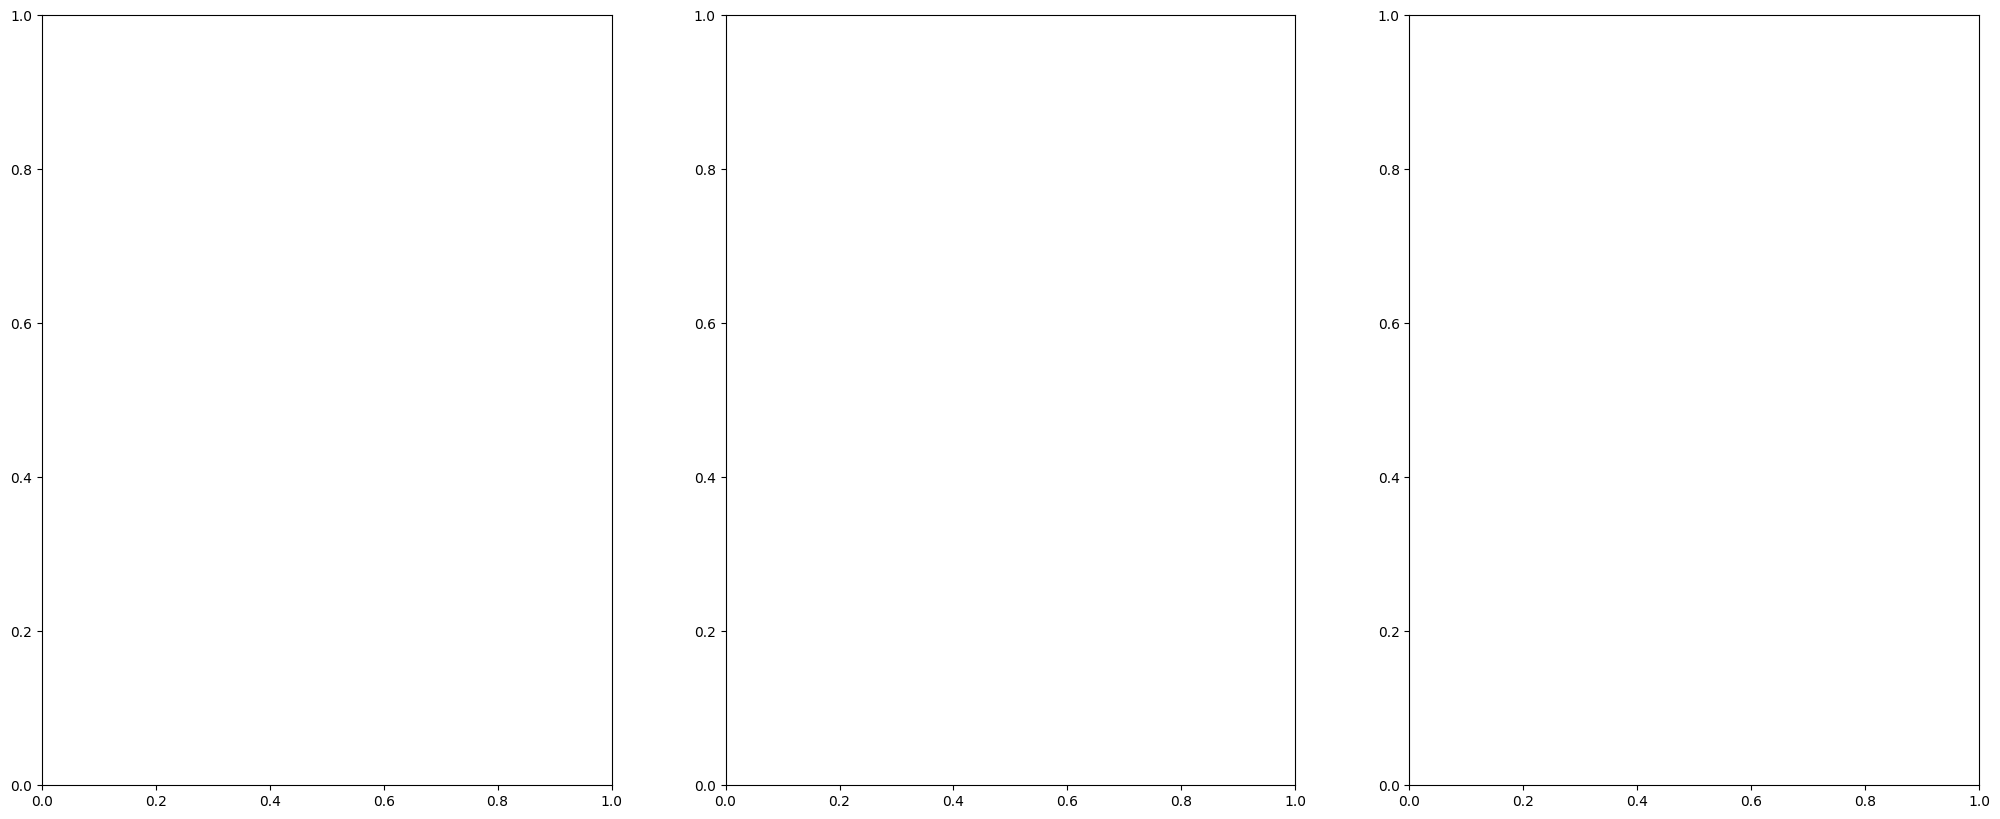

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,10))

# absorption
ax1.imshow(absorption)
ax1.title.set_text('Absorption')

# dark field
ax2.imshow(total_scattering)
ax2.title.set_text('Dark field')

#q dependent
ax3.imshow(image)
ax3.title.set_text('q dependent')


bgsaxsdata = process_data(79, proposal, visit, sdet, sq_range)
bgwaxsdata = process_data(79, proposal, visit, wdet, wq_range)

In [17]:
sq, bgsI, wq, bgwI = azint_data(79, 'Both')

NameError: name 'azint_data' is not defined

In [18]:
def extI(data, axis):
    return np.sum(data, axis=axis)/np.count_nonzero(data, axis=axis)

In [19]:
row= 45
col= 31
azi_ini = 0
azi_end = 180
azi_reading = (wazi[azi_ini]+wazi[azi_end-1])/2
# Night_scan #1, no pre-load
# 61 - 40%, 62 - 50%, 63 - 60%, 64 - 65%, 65 - 70%, 66 - 75%, 67 - 80%, 68 - 85%, 69 - 90%
# Night_scan #2, pre-load
# 191 - 50%, 192 - 60%, 193 - 65%, 193 - 70%, 194 - 75%, 195 - 80%, 196 - 85%, 197 - 90%
#RH = np.array([40, 50, 60, 65, 70, 75, 80, 85, 90])
RH = np.array([50, 60, 65, 70, 75, 80, 85, 90])
fig, ax = plt.subplots(1,3, layout='constrained', figsize=(12,4))
fig.suptitle(f'RH row:{row}_col:{col}_azireading:{azi_reading}', fontsize=15)
for index, scannr in enumerate(zip(range(191, 198), RH)):
    with h5py.File('azint/scan-{:04d}_eiger_integrated.h5'.format(scannr[0]), 'r') as data:
        sI = extI(data['entry/data2d/cake'][row*col, azi_ini:azi_end], 0) - 0.9*extI(bgsI[row,col, azi_ini:azi_end], 0)
    #saxsI = saxsdata['I']-bgsaxsdata['I']
    with h5py.File('azint/scan-{:04d}_lambda_integrated.h5'.format(scannr[0]), 'r') as data:
        wI = extI(data['entry/data2d/cake'][row*col, azi_ini:azi_end], 0) - 0.9*extI(bgwI[row,col, azi_ini:azi_end], 0)
    #waxsI = waxsdata['I']-bgwaxsdata['I']
    ax[0].set_title('SAXS')
    #ax[0].pcolormesh(saxsdata)
    ax[0].loglog(sq, sI*3**index, '.', markersize=3, label='RH {}%'.format(scannr[1]))
    #ax[0].set_ylim([1e-2,1e5])
    ax[0].set_ylabel('$Iq^{2}$')
    #ax[0].set_xlim([0.01,0.35])
    ax[0].set_xlabel(r'q $(\AA^{-1})$')
    ax[0].legend(loc=3, fontsize=8, reverse=True)
    
    ax[1].set_title('WAXS_(102)_(200)')
    #ax[1].plot(wq, wI+5*index, '-', label='RH {}%'.format(scannr[1]))
    ax[1].plot(wq, wI, '-', label='RH {}%'.format(scannr[1]))
    ax[1].set_xlim([1.2, 1.8])
    ax[1].axvline(1.59, ls='--', c='k')
    ax[1].set_xlabel(r'q $(\AA^{-1})$')
    ax[1].set_ylabel('Intensity (a.u.)')
    ax[1].legend(fontsize=8, reverse=True)
    
    ax[2].set_title('WAXS_(004)')
    ax[2].plot(wq, wI+5*index, '-', label='RH {}%'.format(scannr[1]))
    ax[2].set_xlim([2.35, 2.55])
    ax[2].set_xlabel(r'q $(\AA^{-1})$')
    ax[2].axvline(2.426, ls='--', c='k')
    ax[2].set_ylabel('Intensity (a.u.)')
    ax[2].legend(fontsize=8, reverse=True)
    #handles, labels = ax.get_legend_handles_labels()
    #ax[1].pcolormesh(waxsdata)
plt.show()
fig.savefig(f'images/Preload_Humidity_dependence_Row {row}_Col{col}_Azi {azi_reading}.png')

NameError: name 'wazi' is not defined

In [20]:
def flip_data(data):
    #I = data.reshape((50,61,180,2000))
    I_flipped = np.copy(data)
    I_flipped = I_flipped.reshape((61,50,180,2000))
    #if snake_scan == True:
    I_flipped[1::2,:] = I_flipped[1::2,::-1]
    return I_flipped

In [21]:
def azint_data(scannr, mode): #mode is "SAXS", "WAXS", or "Both"
    if mode in ['SAXS', 'Both']:
        with h5py.File('azint/scan-{:04d}_eiger_integrated.h5'.format(scannr), 'r') as data:
            sI = data['entry/data2d/cake']
            sI = flip_data(sI)
            sq = data['entry/data2d/q'][:]
            #sazi = data['entry/data2d/azi'][:]
    if mode in ['WAXS', 'Both']:
        with h5py.File('azint/scan-{:04d}_lambda_integrated.h5'.format(scannr), 'r') as data:
            wI = data['entry/data2d/cake']
            wI = flip_data(wI)
            wq = data['entry/data2d/q'][:]
    if mode == 'SAXS':
        return sI
    elif mode == 'WAXS':
        return wI
    else:
        return sq, sI, wq, wI

In [22]:
with h5py.File('azint/scan-{:04d}_eiger_integrated.h5'.format(69), 'r') as data:
    sq = data['entry/data2d/q'][:]
    sazi = data['entry/data2d/azi'][:]
with h5py.File('azint/scan-{:04d}_lambda_integrated.h5'.format(69), 'r') as data:
    wq = data['entry/data2d/q'][:]
    wazi = data['entry/data2d/azi'][:]

In [23]:
def extractdata(roposal,visit, scan, det, flyscan)   #Loading data
    data = load_data(proposal,visit, scan, det, fly_scan)
    
    # absorption contrast
    I = data['i_t'].reshape(data['shape'])
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:] = I_flipped[1::2,::-1]
    absorption = I_flipped
    
    
    # dark field
    I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))
    
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
    data_scat = I_flipped
    total_scattering = np.average(data_scat,axis=(2,3))
    total_scattering /= absorption
    
    return total_scattering

SyntaxError: invalid syntax (1671803833.py, line 1)

# Orientation analysis

### Data processing

In [13]:
#Defining angular range for background fitting (to subtract gaps) 
ind_ang = np.array([np.arange(0,26)])


ind_ang1 = np.array([np.arange(0,26)])
ind_ang2 = np.array([np.arange(66,113)])
ind_ang3 = np.array([np.arange(118,180)])

ind_ang = np.concatenate((ind_ang1,ind_ang2),axis=1)
ind_ang = np.concatenate((ind_ang,ind_ang3),axis=1)
print(ind_ang.shape)

#Background subtraction and cropping
data_azi = np.sum(data_scat[:,:,:,ind_q],axis=3) - 0.5*((len(ind_q)/len(ind_bg1))*np.sum(data_scat[:,:,:,ind_bg1],axis=3)+(len(ind_q)/len(ind_bg2))*np.sum(data_scat[:,:,:,ind_bg2],axis=3)) 
data_azi = np.vstack(data_azi)
print(data_azi.shape)




#A,f,phi = sin_param_estimate(data_azi[1000,:])
A,f,phi = sin_param_estimate(data_azi[5205,:])
#A,f,phi = sin_param_estimate(data_azi[5314,:])

print(A)
print(f)
print(phi)


plt.figure()
#plt.plot(data_azi[1000,:])
plt.plot(2*ind_ang, data_azi[5205, ind_ang])
#plt.plot(data_azi[5314,:])
#plt.plot(A*np.cos(2*np.pi*n*f+phi), 'r--')
plt.title('degree_orient')
plt.ylim([-1000,1000])
plt.show()




NameError: name 'np' is not defined

In [14]:
'''
filelist = widgets.Dropdown(
    options=[(os.path.basename(x), x) for x in sorted(glob(filepath+'/Reshaped/**/Re*.h5', recursive=True))],
    #value='2',
    description='File:',
    disabled=False,
)
'''
#filelist = widgets.

x = widgets.IntSlider(
    value = 15,
    min = 0,
    max = 30,
    description='y range:',
    disabled=False,
    continuous_update=False,
)

y = widgets.IntSlider(
    value = 15,
    min = 0,
    max = 30,
    description='x range:',
    disabled=False,
    continuous_update=False,
)

q = widgets.IntRangeSlider(
    value=[300, 1000],
    min=0,
    max=1023,
    step=1,
    description='Q range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

theta = widgets.IntRangeSlider(
    value=[2, 285],
    min=0,
    max=360,
    description = 'Azimuthal:',
    disabled=False,
    continuous_update=False
)

'''
def g(file):
    rawfilename = os.path.basename(os.path.dirname(file))+'/'+ os.path.basename(file)[5:11]
    #print(rawfilename)
    with h5py.File(os.path.dirname(filepath)+'/raw/{}.h5'.format(rawfilename), 'r') as f:
        dy = len(f['/entry/measurement/sy'])
        y = len(f['/entry/measurement/pseudo/y'])
        x.max = dy
        y.max = y//dy
    
widgets.interactive_output(g, {'file': filelist})
'''

def f(file, q, x, y, theta):
    #clear_output(wait=False)
    #print(file)
    data = h5py.File(file, 'r')['I']
    w = h5py.File(file, 'r')['q'][:]
    azi = h5py.File(file, 'r')['azi'][:]
    rawfilename = os.path.basename(os.path.dirname(file))+'/'+ os.path.basename(file)[5:11]
    #print(rawfilename)
    #with h5py.File(os.path.dirname(filepath)+'/raw/{}.h5'.format(rawfilename), 'r') as f:
    #    dy = len(f['/entry/measurement/sy'])

    #data = data.reshape(dy, len(data)//dy, 360, 1024)
    
    fig, axs0 = plt.subplots(1, 3, constrained_layout=True, figsize= (18,6))

    axs0[0].pcolormesh(np.sum(data[:,:,theta[0]:theta[1], q[0]:q[1]], axis=(2,3)), norm=LogNorm(), shading='auto')
    #cursor = Cursor(axs0[0], useblit=True, color='red', linewidth=2)
    axs0[0].axhline(x, color='k')
    axs0[0].axvline(y, color='r')
    axs0[1].semilogy(w, np.sum(data[x,y,theta[0]:theta[1],:], axis=0)/np.count_nonzero(data[x,y,theta[0]:theta[1],:], axis=0), '-')
    axs0[1].axvline(w[q[0]], color='k')
    axs0[1].axvline(w[q[1]], color='r')
    axs0[2].plot(azi,np.mean(data[x,y,:,q[0]:q[1]], axis=1), '-')
    axs0[2].axvline(azi[theta[0]])
    axs0[2].axvline(azi[theta[1]], color='r')

    fig.suptitle(os.path.basename(file))
    plt.show()

#out = widgets.interactive_output(f, {'file': filelist, 'q': q, 'x': x, 'y': y, 'theta': theta})
UI = widgets.VBox([q, y, x, theta])

display(UI, out)
clear_output(wait=True)

NameError: name 'widgets' is not defined

In [15]:
datapath = os.getcwd()
datapath

NameError: name 'os' is not defined

In [16]:
class Simpleplot:
    def __init__(self, scannum, foldername, samplename, sfactor, wfactor, time, timescale, saxsbackground, waxsbackground, subfirstline = False):
        self.scannum =  scannum
        self.foldername = foldername
        self.samplename = samplename
        self.sfactor = sfactor
        self.wfactor = wfactor
        self.time = time
        self.timescale = timescale
        self.subfirstline = subfirstline
        self.sbackground = saxsbackground
        self.wbackground = waxsbackground
        
        self.Name = widgets.IntText(
            #options=[(os.path.basename(x), x) for x in sorted(glob(datapath+'/azint/*.h5', recursive=True))],
            value=self.scannum,
            description='Scan Num',
            disabled=False,
        )
        
        self.x = widgets.FloatSlider(
            value = self.sfactor,
            min = 0,
            max = 1,
            step = 0.001,
            description='S-factor:',
            disabled=False,
            continuous_update=False,
        )

        self.y = widgets.FloatSlider(
            value = self.wfactor,
            min = 0,
            max = 1,
            step = 0.001,
            description='W-factor:',
            disabled=False,
            continuous_update=False,
        )

        self.t  = widgets.IntRangeSlider(
            value=[10, 15],
            min=0,
            max=self.timescale,
            step=1,
            description='Time:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
        )
        
    def plot(self, num, factor1, factor2, t):
        init = 350
        fin = 820
        #factor = 0.8
        fig, ax =plt.subplots(4, 1, figsize=(3,6))
        cdI, cdw = azint_data(num)
        '''
        with h5py.File(datapath+"{}/scan-{:04}_eiger_integrated.h5".format(self.foldername, num), 'r') as f:
            cI = f['entry/data1d/I'][:,30:580]/0.1
            q = f['entry/data1d/q'][30:580]
            #cdI = np.transpose(cI.T/np.trapz(cI*q**2, q))
            cdI = cI
            cdI -= factor1 * np.mean(self.sbackground, axis=0)
            #self.updateimtescale(len(cI))

        with h5py.File(datapath+"{}/scan-{:04}_lambda_integrated.h5".format(self.foldername, num), 'r') as f:
            cw = f['entry/data1d/I'][:,init:fin]/0.1
            wq = f['entry/data1d/q'][init:fin]
            cdw = np.transpose(cw.T/np.trapz(cw*wq**2, wq))
            cdw -= factor2 * np.mean(self.wbackground, axis=0)
            if self.subfirstline:
                cdw -= cdw[0]
        '''
        ax[0].pcolormesh(q, range(len(cdI)), cdI, norm=LogNorm(), shading='auto')
        ax[0].axhline(t[0], c='b', linestyle = 'dashed')
        ax[0].axhline(t[1], c='r', linestyle = 'dashed')
        ax[1].loglog(q, cdI[t[0]], 'b-')
        ax[1].loglog(q, cdI[t[1]], 'r-')
        ax[2].pcolormesh(wq, range(len(cdw)), cdw, norm=LogNorm(), shading='auto')
        ax[2].axhline(t[0], c='b', linestyle = 'dashed')
        ax[2].axhline(t[1], c='r', linestyle = 'dashed')

        if t[0] < 5 :
            ax[3].plot(wq, np.mean(cdw[0:t[0]+5], axis=0), 'b-')
        else:
            ax[3].plot(wq, np.mean(cdw[t[0]-5:t[0]+5], axis=0), 'b-')

        if t[1] > 4995 :
            ax[3].plot(wq, np.mean(cdw[t[1]-5:-1], axis=0), 'r-')
        else:
            ax[3].plot(wq, np.mean(cdw[t[1]-5:t[1]+5], axis=0), 'r-')

        ax[0].set_title(self.samplename)
        ax[0].set_xscale('log')
        plt.show()

    def Interact(self):
        return widgets.interactive_output(self.plot, {'num': self.Name, 'factor1': self.x, 'factor2': self.y, 't':self.t})

    def layout(self):
        return widgets.VBox([self.Name, self.x, self.y, self.t, self.Interact()])

    def Display(self):
        display(self.layout())
#clear_output(wait=True)

In [17]:
Lignin = Simpleplot(69, '/azint/', 'Lignin', 0.9, 0.9, 10, 100, bgsI, bgwI)
Lignin.Display()

NameError: name 'bgsI' is not defined

In [18]:
rhsI, rhwI = azint_data(141, 'Both')

NameError: name 'h5py' is not defined

In [19]:
bgrhwI = rhwI - bgwI

NameError: name 'rhwI' is not defined

In [20]:
#plt.plot(wq, np.sum(rhwI[-10,-10], axis=0)/np.count_nonzero(rhwI[-10,-10], axis=0), '.', label= 'raw')
plt.plot(wq, np.sum(bgrhwI[-10,-10], axis=0)/np.count_nonzero(bgrhwI[-10,-10], axis=0), '.', label = 'Bg_removed')
#plt.plot(wq, np.sum(bgwI[-10,-10], axis=0)/np.count_nonzero(bgwI[-10,-10], axis=0), '.', label ='Bg')
#plt.xlim([2.25, 2.65])
#plt.xlim([1.3, 1.9])
plt.legend()

NameError: name 'plt' is not defined

In [62]:
def Porod(q, scale, exponent):
    return scale*q**exponent
def mp(q, scale, C1, C2):
    return scale/(1+C1*q**2+C2*q**4)
def ful3(x, p1,p2,p3,p4,p5,p6):
    return p1*x**(-p2) + p3/(1+p4*x**2+p5*x**4) + p6
def ful4(x, p1,p2,p3,p4,p5,p6,p7,p8):
    return p1*x**(-p2) + p3/(1+p4*x**2+p5*x**4) + p6*np.exp(-(x/p7)**2)+p8
def regen1(x, para):
    porod = para[0]*x**(-para[1]) + para[-1]
    mp = para[2]/(1+para[3]*x**2+para[4]*x**4) + para[-1]
    return porod, mp
def regen2(x, para):
    porod = para[0]*x**(-para[1]) + para[-1]
    mp = para[2]/(1+para[3]*x**2+para[4]*x**4) + para[-1]
    gau = para[5]*np.exp(-(x/para[6])**2)+para[-1]
    return porod, mp, gau

def regen3(x, para):
    porod = para[0]*voigt_profile(x-para[1], para[2], para[3])
    mp = para[4]*voigt_profile(x-para[5], para[6], para[7])
    gau = para[8]*x**(-para[9])+para[10]
    return porod, mp, gau

def cellu(x, *p):
    p = np.array([*p]).flatten()
    #print(p.shape)
    #f = p[-3]*x**(-p[-2]) + p[-1]
    f = p[-3]*x + p[-1] 
    temp = p[:-3].reshape(int(len(p[:-3])/4), 4)
    for row in temp:
        f += row[0]*voigt_profile(x-row[1], row[2], row[3])
    return f

def cryl(splitpeak, q):
    rnum = len(splitpeak)
    cry = 0
    total = 0
    width = []
    peak = []
    for row in range(rnum):
        I = splitpeak[row,0]*voigt_profile(q-splitpeak[row,1], splitpeak[row,2], splitpeak[row,3])
        total += np.trapz(I, q)
        width.append(np.sqrt(splitpeak[row,2]**2+0.2166*splitpeak[row,3]**2)+0.5346*splitpeak[row,3])
        peak.append(splitpeak[row, 1])
        #print(total)
        if row < rnum-2:
            cry = total
            #print(cry)
    width = np.array(width)
    peak = np.array(peak)
    return cry/total*100, width, 2*np.pi/width, peak, 2*np.pi/peak

In [63]:
def fitting(func, x, y, fitp):
    #fitting protocal for carbon fibers
    #low = [0, 1.5, 0, 1e-5, 0, 1e-7]
    #upp = [1e-1, 4.2, 6, 10, 10, 4]
    #adjust = np.array(fitp)
    #low = adjust[:-1].reshape(13,4)
    #low[:,0] = low[:,0]*0.2
    #low[:,1] = low[]
    low = list(np.array(fitp)*0.1)
    upp = list(np.array(fitp)*10)

    popt, pcov = curve_fit(func, x, y, p0=fitp, sigma = np.sqrt(np.abs(y)), bounds=(low, upp), method='trf')
    #popt, pcov = curve_fit(func, x, y, p0=fitp, sigma = y, method='dogbox')
    return popt, func(x, *popt)

In [23]:
q1_range = [1.3, 1.9]
#q2_range = [2.25, 2.65]

q1_min_index = np.argmin(np.abs(wq-q1_range[0]))
q1_max_index = np.argmin(np.abs(wq-q1_range[1]))

#q2_min_index = np.argmin(np.abs(wq-q2_range[0]))
#q2_max_index = np.argmin(np.abs(wq-q2_range[1]))

fitq1 = wq[q1_min_index:q1_max_index]
#fitq2 = wq[q2_min_index:q2_max_index]

fitp1 = {
    'P102': [10, 1.46, 0.3, 0.2],
    'P200': [20, 1.52, 0.3, 0.2],
    'base': [1.5e-4, 2, 1.5e-5]
}

'''
fitp2 = {
    'P004': [0.6e-5, 24.2, 0.3, 0.2],
    'P': [0.8e-5, 25.2, 0.5, 0.3],
    'base': [1.5e-4, 2, 1.5e-5]
}
'''

for scannr in range(61, 62):
    with h5py.File('azint/scan-{:04d}_lambda_integrated.h5'.format(scannr), 'r') as data:
        wI = data['entry/data1d/I']
        #wI = flip_data(wI)

        para1 = list(itertools.chain(*fitp1.values()))
        #para2 = list(itertools.chain(*fitp2.values()))
        # carbon fiber

        paras = []
        #pcovs = []
        Porods = []
        mps = []
        gaus = []
        fullfits = []

        #for n in tqdm(np.arange(719, -1, -1, dtype=int)):
        for n in tqdm(range(len(wI))):
            for azi in range(180):
                try:
                    I_fit = fitting(cellu, fitq1, wI[n, azi, q1_min_index:q1_max_index], para1)
                    #print(I_fit[0])
                except:
                    I_fit = para1, cellu(fitq1, *para1)
                para = I_fit[0]
                paras.append(para)
                #pcovs.append(I_fit[1])


                #split = regen1(fitq, I_fit[0])
                split = regen3(fitq1, I_fit[0])
                Porods.append(split[0])
                mps.append(split[1])
                gaus.append(split[2])
                fullfits.append(I_fit[1])
                if n % 100 == 0 & azi == 90:
                    plt.loglog(fitq1, I[n, q_min_index:-100], '.', label=name)
                    plt.loglog(fitq1, I_fit[2], '-', label='fit')
                    plt.loglog(fitq1, split[0], '--', label='Porod')
                    plt.loglog(fitq1, split[1], '--', label='mp')
                    plt.loglog(fitq1, split[2], '--', label='gau')
                    #plt.annotate((0.1, 5), I_fit[0])
                    plt.legend()
                    plt.show()
        paras = np.flipud(np.asarray(paras))
        paras = para.reshape((50,60,180,11))
        #pcovs = np.flipud(np.asarray(pcovs))
        Porods = np.flipud(np.asarray(Porods))
        Porods = Porods.reshape((50,60,180,len(fitp1)))
        mps = np.flipud(np.asarray(mps))
        mps = mps.reshape((50,60,180,len(fitp1)))
        gaus = np.flipud(np.asarray(gaus))
        gaus = gaus.reshape((50,60,180,len(fitp1)))
        fullfits = np.flipud(np.asarray(fullfits))
        fullfits = fullfits.reshape((50,60,180,len(fitp1)))


        with h5py.File(r'scan_{}_(200)_fitting.h5'.format(scannr), 'w') as sfit:
            sfit.create_dataset('q', data = fitq)
            sfit.create_dataset('popt', data = paras)
            sfit.create_dataset('pcov', data = pcovs)
            curves = sfit.create_group('curves')
            curves.create_dataset('Porod', data = Porods)
            curves.create_dataset('mp', data = mps)
            curves.create_dataset('full', data = fullfits)
            curves.create_dataset('gau', data = gaus)

    #np.savetxt(name[:-4]+'_rawI.txt', I)

    #np.savetxt(name[7:-4]+'_fitcurve.txt', np.asarray(collector).T)
    #np.savetxt(name[7:-4]+'_fitpara.txt', I_fit[0])
    #np.savetxt(name[:-7]+'_fitsepcurve.txt', np.array(split).T)
    #np.savetxt(name[:-7]+'_realDist.txt', np.array(RealD).T)
    #np.savetxt(name[:-7]+'_fitwidth.txt', np.array(cryl(splitpeak, q)[1:]).T)

NameError: name 'np' is not defined

In [14]:
q_range = [2.25, 2.65]
q_min_index = np.argmin(np.abs(wq-q_range[0]))
q_max_index = np.argmin(np.abs(wq-q_range[1]))


In [268]:
test = azint_data(229, 'SAXS') 
reshape_test = test.reshape(61,50,-1,5, 2000)
reshape_test = np.mean(reshape_test, axis=3)
reshape_test.shape

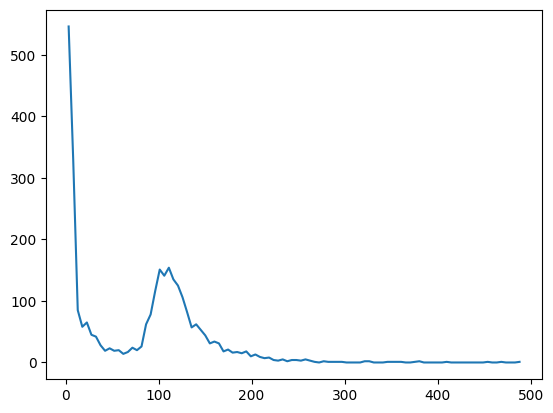

In [283]:
#TestMask = np.mean(test, axis=(2,3))
TestMask = test[:,:,50,50]
hist, bins = np.histogram(TestMask, bins=100)
binning = (bins[:-1]+bins[1:])/2
plt.plot(binning, hist)

In [289]:
Mask = TestMask < 50 # np.percentile(TestMask, 40)

In [247]:
np.percentile(TestMask, 40)

8.128489112854004

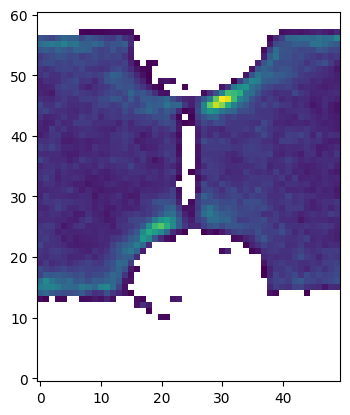

In [290]:
plt.imshow(np.ma.masked_array(TestMask, mask=Mask), origin='lower')

In [15]:
def downsize_data(data):
    reshape_data = data.reshape(61, 50, -1, 5, 2000)
    reshape_data = np.mean(reshape_data, axis=3)
    return reshape_data

In [16]:
def extract_data(scannr):
    with h5py.File(rawpath+'scan-{:04d}.h5'.format(scannr), 'r') as master:
        I_t = master['entry/instrument/albaem-e01_ch1/data'][:]
        I_t = I_t.reshape(61, 50)
    sq, sI, wq, wI = azint_data(scannr, 'Both')
    sI = downsize_data(sI)/I_t[:,:,np.newaxis,np.newaxis]
    wI = downsize_data(wI)/I_t[:,:,np.newaxis,np.newaxis]
    
    q1_range = [1.3, 1.9]
    q2_range = [2.25, 2.65]
    
    q1_min_index = np.argmin(np.abs(wq-q1_range[0]))
    q1_max_index = np.argmin(np.abs(wq-q1_range[1]))

    q2_min_index = np.argmin(np.abs(wq-q2_range[0]))
    q2_max_index = np.argmin(np.abs(wq-q2_range[1]))
    
    with h5py.File('downsized_data/ds_scan-{:04d}.h5'.format(scannr), 'w') as ds:
        saxs = ds.create_group('saxs')
        saxs.create_dataset('I', data= sI)
        saxs.create_dataset('q', data= sq)
        waxs = ds.create_group('waxs')
        waxs.create_dataset('I_200', data = wI[:,:,:,q1_min_index:q1_max_index])
        waxs.create_dataset('q_200', data = wq[q1_min_index:q1_max_index])
        waxs.create_dataset('I_004', data = wI[:,:,:,q2_min_index:q2_max_index])
        waxs.create_dataset('q_004', data = wq[q1_min_index:q1_max_index])

In [109]:
def voigtwidth(wg, wL):
    return 0.5346*wL + np.sqrt(0.2166*wL**2+wg**2)

In [321]:
import time
t0 = time.time()
extract_data(79)
t1 = time.time()
dt = t1-t0
dt

12.789945602416992

In [323]:
for n in range(234,243):
    extract_data(n)

In [74]:
fitp1 = {
    'P102': [2, 1.46, 0.01, 0.02],
    'P200': [5, 1.62, 0.01, 0.02],
    'base': [1.5e-4, 2, 15]
}


In [177]:
def fitting_1d(x, data, fitp, filename, maskindex):
    para = list(itertools.chain(*fitp.values()))
    shape = data.shape[:-1]
    fitpara = np.zeros((shape[0], shape[1], 11))
    fitcurve = np.zeros(data.shape)
    for pair in maskindex:
        try:
            I = data[pair[0], pair[1]]
            I_fit = fitting(cellu, x, I, para)
            fitpara[pair[0], pair[1]] = I_fit[0]
            fitcurve[pair[0], pair[1]] = I_fit[1]
        except RuntimeError as e:
            pass
    with h5py.File('fitting/scan-{:04d}_102_200_1d.h5'.format(filename), 'w') as f:
        f.create_dataset('fit_para', data =fitpara)
        f.create_dataset('fit_curve', data =fitcurve)

In [108]:
with h5py.File('azint/scan-{:04d}_lambda_integrated.h5'.format(79), 'r') as ds:
    bgwI = ds['entry/data1d/I']
    #wq = ds['waxs/q_200'][:]
    for n in range(235, 243): # update the start 235 and stop 242+1 number
        with h5py.File('azint/scan-{:04d}_lambda_integrated.h5'.format(n), 'r') as ds:
            wI = ds['entry/data1d/I'][:] - bgwI[:]
            wI = wI.reshape(61,50,2000)
            wI[1::2,:] = wI[1::2,::-1]
            mask = np.mean(wI, axis=-1)
            mask = mask < np.mean(mask) #np.percentile(wI, 50)
            maskindex = np.argwhere(mask==False)

            wq = ds['entry/data1d/q'][:]

            para = list(itertools.chain(*fitp1.values()))
            
            q_range = [1.3, 1.9]
            q_min_index = np.argmin(np.abs(wq-q_range[0]))
            q_max_index = np.argmin(np.abs(wq-q_range[1]))
            
            #print(np.ma.getmask(wI[:,:,2]))
            fitting_1d(wq[q_min_index:q_max_index], wI[:,:,q_min_index:q_max_index], fitp1, n, maskindex)
            
            #I_fit = fitting(cellu, wq[q_min_index:q_max_index], wI[30,20,q_min_index:q_max_index], para)
            #print(I_fit[0])
            
            #coarse strain
            
            #max_indices = np.argmax(wI, axis=2)
            #fake_strain = wq[max_indices]
            #fake_strain -= np.mean(fake_strain)
            #fig, ax = plt.subplots(1,1)
            #im = ax.pcolormesh(fake_strain[:,:],norm=LogNorm())
            #plt.colorbar(im, ax=ax)
            #plt.plot(wq[q_min_index:q_max_index], wI[30,20,q_min_index:q_max_index], '.')
            #plt.plot(wq[q_min_index:q_max_index], I_fit[1])

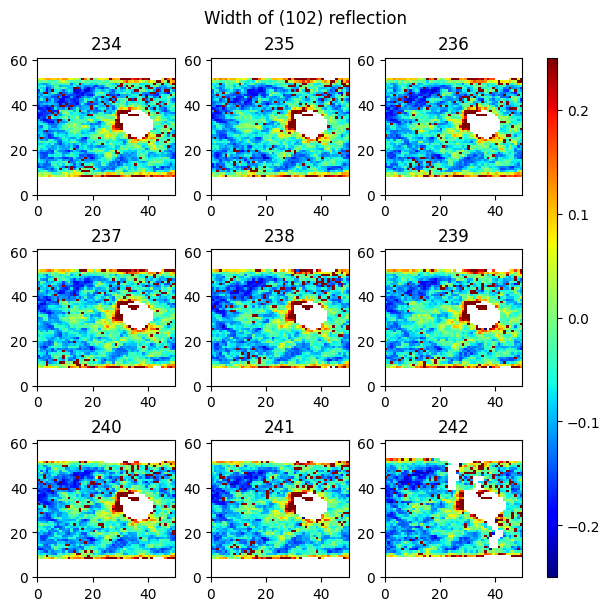

In [176]:
fig, ax = plt.subplots(3, 3, layout='constrained', figsize=(6,6)) # 3 by 3 is the number from 235 to 242
fig.suptitle('Width of (102) reflection')
for scan, axs in zip(range(234, 243), ax.flatten()): # update the start 235 and stop 242+1 number
    with h5py.File('fitting/scan-{:04d}_1d.h5'.format(scan), 'r') as ds:
        #peakposition = voigtwidth(ds['fit_para'][:,:,6], ds['fit_para'][:,:,7])  #(200) reflection
        peakposition = voigtwidth(ds['fit_para'][:,:,2], ds['fit_para'][:,:,3])   #(102) reflection
        #peakposition = ds['fit_para'][:,:,0]
        mask = peakposition == 0
        peakposition = np.ma.masked_array(peakposition, mask=mask)
        #peakposition = (np.mean(peakposition)/peakposition - 1)*100
        peakposition = peakposition/np.mean(peakposition)-1
        im = axs.pcolormesh(peakposition, vmin=-0.25, vmax=0.25, cmap='jet')
        axs.set_title(scan)
fig.colorbar(im, ax=ax, fraction=0.1, aspect=50)
fig.savefig('images/Width_102_nr{}_nr{}.png'.format(234, 242))

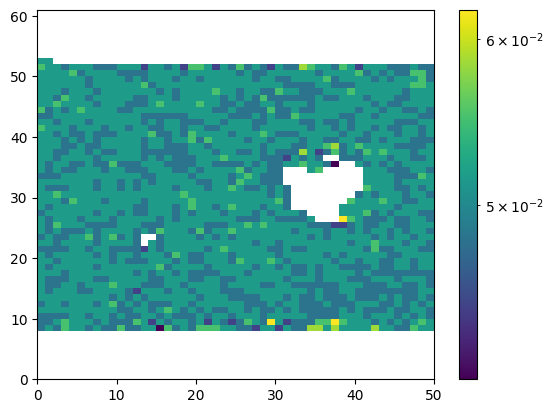

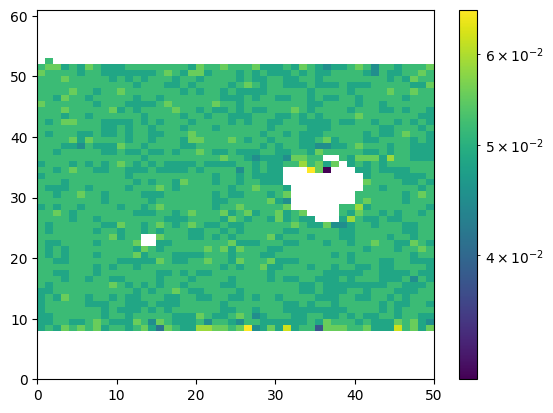

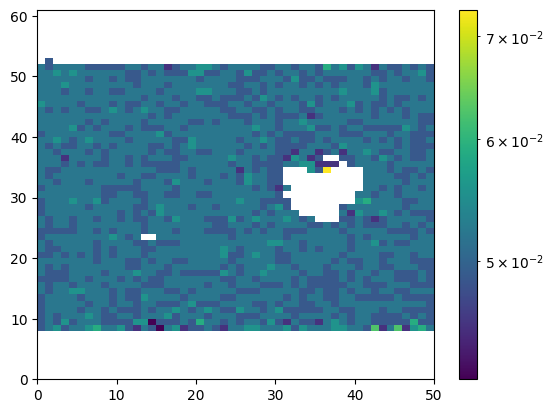

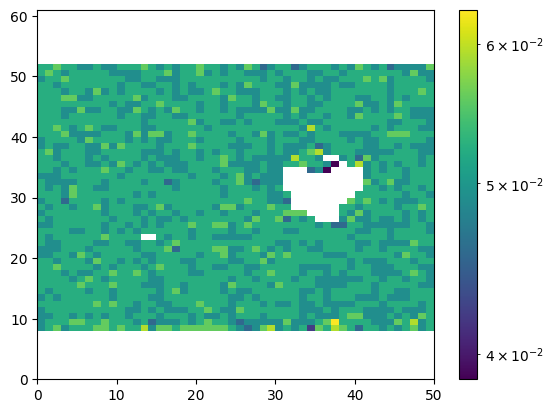

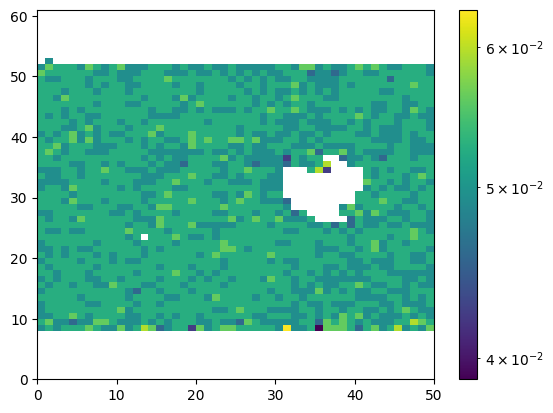

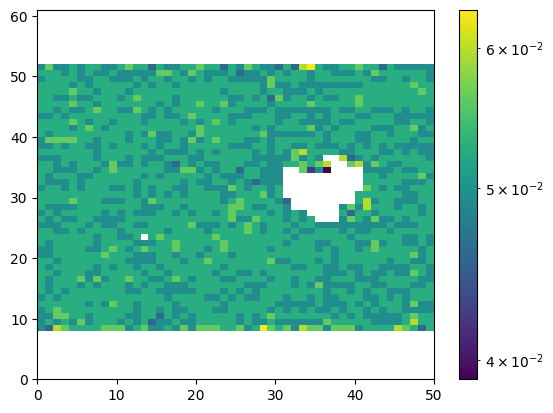

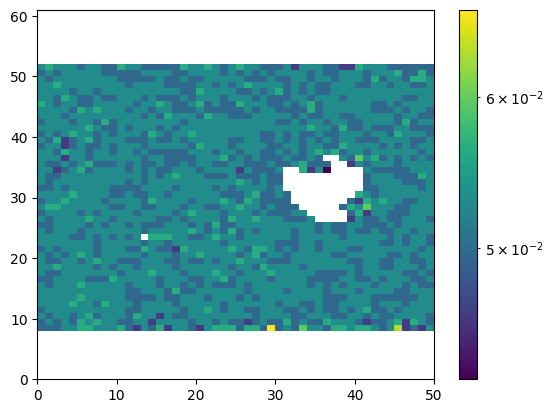

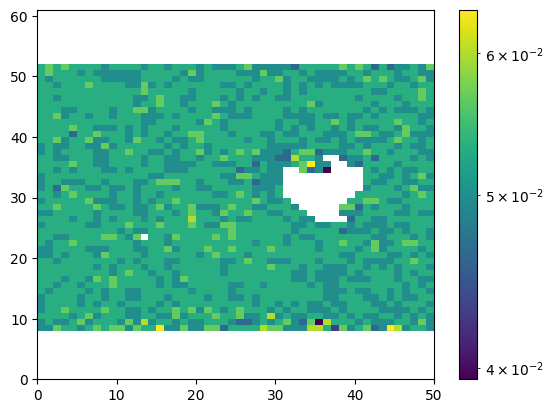

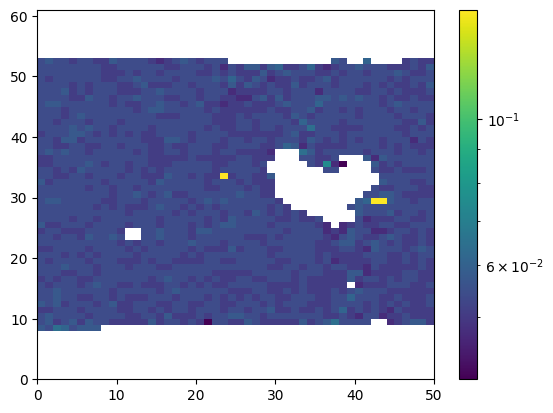

In [412]:
with h5py.File('downsized_data/ds_scan-{:04d}.h5'.format(79), 'r') as ds:
    bgwI = ds['waxs/I_004']
    #wq = ds['waxs/q_200'][:]
    for n in range(234, 243):
        with h5py.File('downsized_data/ds_scan-{:04d}.h5'.format(n), 'r') as ds:
            wI = ds['waxs/I_004'][:] - bgwI[:]
            mask = wI < np.mean(wI)
            wI = np.ma.masked_array(wI, mask = mask)
            wq = ds['waxs/q_004'][:]

            max_indices = np.argmax(wI, axis=3)

            fake_strain = wq[max_indices]
            fake_strain -= np.mean(fake_strain)
            fig, ax = plt.subplots(1,1)
            im = ax.pcolormesh(fake_strain[:,:,8],norm=LogNorm())
            plt.colorbar(im, ax=ax)

    #plt.pcolormesh(wI[:,:,30,87])

In [120]:
help(voigt_profile)

Help on ufunc:

voigt_profile = <ufunc 'voigt_profile'>
    voigt_profile(x1, x2, x3, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    voigt_profile(x, sigma, gamma, out=None)
    
    Voigt profile.
    
    The Voigt profile is a convolution of a 1-D Normal distribution with
    standard deviation ``sigma`` and a 1-D Cauchy distribution with half-width at
    half-maximum ``gamma``.
    
    If ``sigma = 0``, PDF of Cauchy distribution is returned.
    Conversely, if ``gamma = 0``, PDF of Normal distribution is returned.
    If ``sigma = gamma = 0``, the return value is ``Inf`` for ``x = 0``,
    and ``0`` for all other ``x``.
    
    Parameters
    ----------
    x : array_like
        Real argument
    sigma : array_like
        The standard deviation of the Normal distribution part
    gamma : array_like
        The half-width at half-maximum of the Cauchy distribution part
    out : ndarray, optional
        Option